# Loading Data

In [ ]:
import deeplake

ds = deeplake.load('hub://activeloop/fer2013-train')

C:\Users\bagdi\anaconda3\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



-

hub://activeloop/fer2013-train loaded successfully.



In [ ]:
ds.tensors

{'images': Tensor(key='images'), 'labels': Tensor(key='labels')}

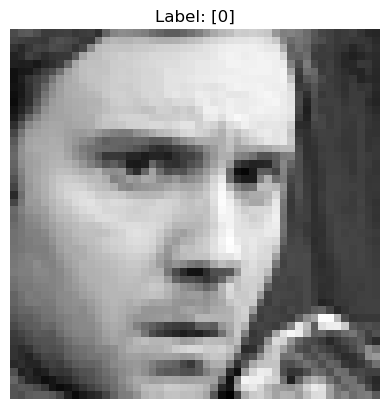

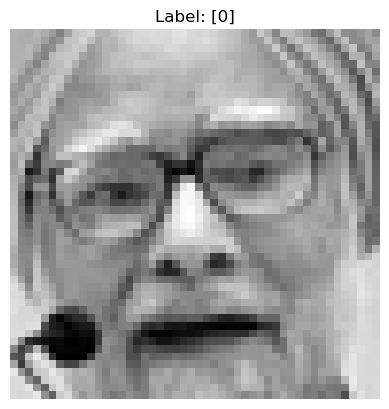

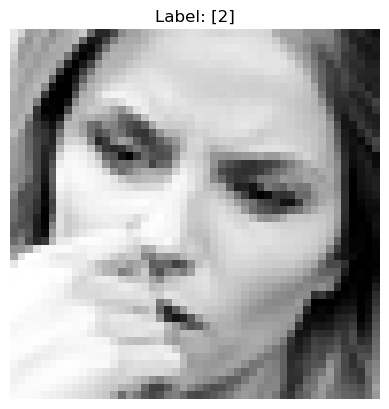

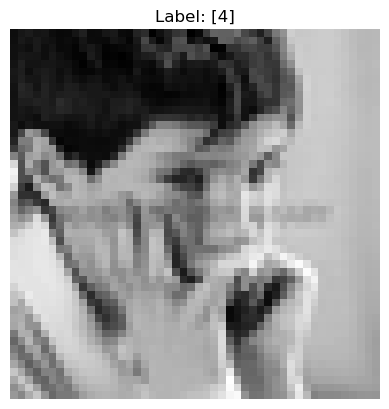

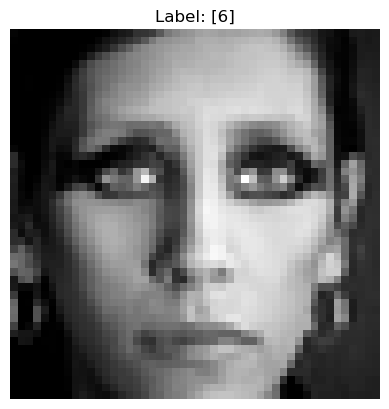

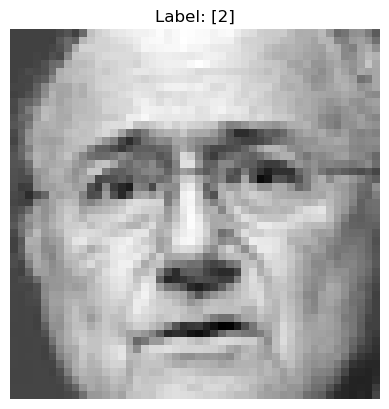

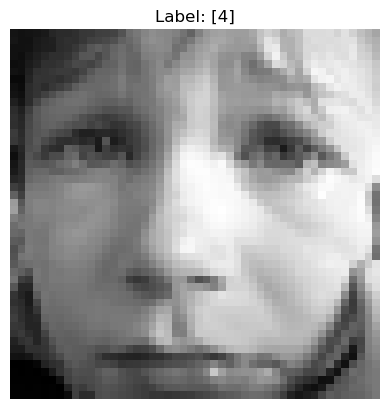

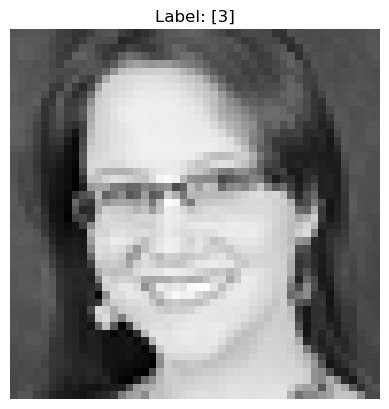

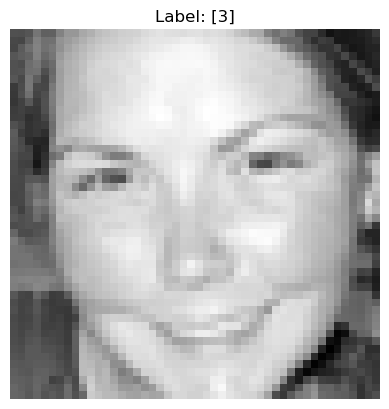

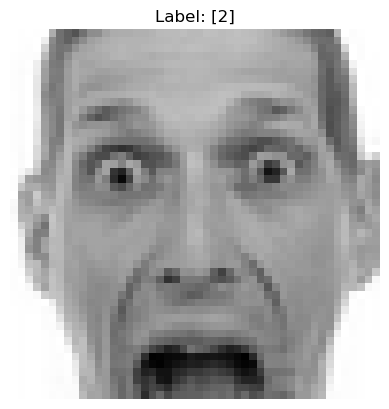

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
    img = ds[i]['images'].numpy()
    label = ds[i]['labels'].numpy()

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Preprocessing Data

In [ ]:
print(ds[0]['images'].numpy())

[[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]


In [ ]:
#Tried for all img first but takes much time
def normalize_image(ds, i):

    img = ds[i]['images'].numpy().astype('float32') / 255.0
    label = ds[i]['labels'].numpy()
    return img, label


In [ ]:
normalize_image(ds,0)[0]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.20392157, 0.16862746,
        0.16078432],
       [0.25490198, 0.23921569, 0.22745098, ..., 0.21960784, 0.20392157,
        0.17254902],
       [0.19607843, 0.16862746, 0.21176471, ..., 0.19215687, 0.21960784,
        0.18431373],
       ...,
       [0.35686275, 0.25490198, 0.16470589, ..., 0.28235295, 0.21960784,
        0.16862746],
       [0.3019608 , 0.32156864, 0.30980393, ..., 0.4117647 , 0.27450982,
        0.18039216],
       [0.3019608 , 0.28235295, 0.32941177, ..., 0.41568628, 0.42745098,
        0.32156864]], dtype=float32)

# Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

indices = list(range(len(ds)))

train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)

val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import os
import random
import numpy as np
os.makedirs("aug", exist_ok=True)

random.seed(42)
sampled_indices = random.sample(train_indices, 100)

X_sample = np.array([ds[i]['images'].numpy() for i in sampled_indices])
y_sample = np.array([ds[i]['labels'].numpy() for i in sampled_indices])

X_sample = X_sample.reshape(-1, 48, 48, 1)

aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

n_augmented = 5

for i in range(len(X_sample)):
    x = X_sample[i].reshape(1, 48, 48, 1)
    label = y_sample[i]

    gen = aug_gen.flow(x, batch_size=1)

    for j in range(n_augmented):
        aug_img = next(gen)[0]
        img_to_save = array_to_img(aug_img)
        filename = f"label_{label}_img{i}_aug{j}.png"
        img_to_save.save(os.path.join("aug", filename))

print("Done Augmentation")

Done Augmentation


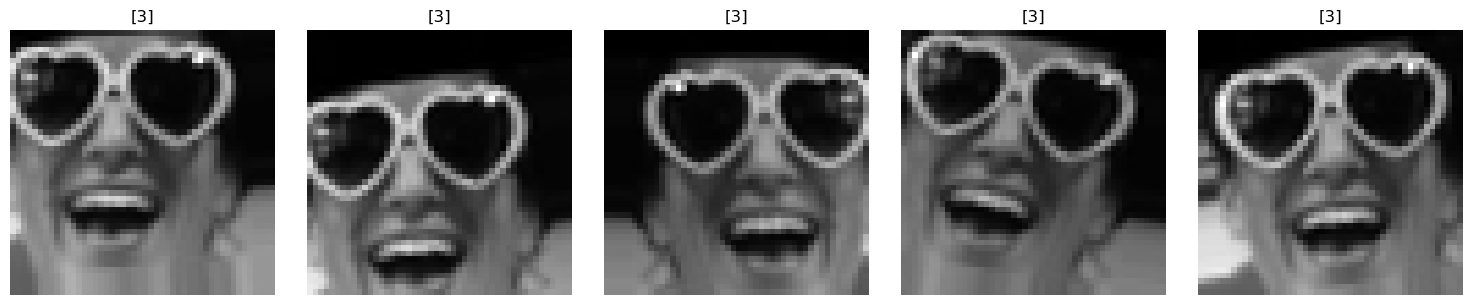

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

target_img_index = 17

aug_folder = "aug"

matching_files = sorted([
    f for f in os.listdir(aug_folder)
    if f"_img{target_img_index}_" in f
])

plt.figure(figsize=(15, 3))
for i, filename in enumerate(matching_files):
    img_path = os.path.join(aug_folder, filename)
    img = Image.open(img_path)

    plt.subplot(1, len(matching_files), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(filename.split("_")[1])  # label
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install keras-tuner

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

X_aug = []
y_aug = []

print("Loading augmented images...")
for fname in tqdm(os.listdir("aug")):
    if fname.endswith(".png"):
        path = os.path.join("aug", fname)
        img = Image.open(path).convert('L')
        img_array = np.array(img).reshape(48, 48, 1) / 255.0
        X_aug.append(img_array)

        label_str = fname.split("_")[1]
        try:
            label = eval(label_str)[0] if label_str.startswith("[") else int(label_str)
        except:
            print(f"Skipped file due to label parse error: {fname}")
            continue
        y_aug.append(label)

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

print("Augmented images loaded:", X_aug.shape, y_aug.shape)

print("Loading original training data from Deep Lake...")
X_train_orig = []
y_train_orig = []

for i in tqdm(train_indices):
    X_train_orig.append(ds[i]['images'].numpy())
    y_train_orig.append(ds[i]['labels'].numpy())

X_train_orig = np.array(X_train_orig).reshape(-1, 48, 48, 1) / 255.0
y_train_orig = np.array(y_train_orig)



Loading augmented images...


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 589.35it/s]


Augmented images loaded: (500, 48, 48, 1) (500,)
Loading original training data from Deep Lake...


100%|████████████████████████████████████████████████████████████████████████████| 22967/22967 [46:30<00:00,  8.23it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
y_train_orig = np.array(y_train_orig).reshape(-1)

# Step 3: Combine original + augmented training data
X_train = np.concatenate((X_train_orig, X_aug), axis=0)
y_train = np.concatenate((y_train_orig, y_aug), axis=0)

print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)

# Step 4: Load validation set
print("Loading validation set...")
X_val = []
y_val = []

for i in tqdm(val_indices):
    X_val.append(ds[i]['images'].numpy())
    y_val.append(ds[i]['labels'].numpy())

X_val = np.array(X_val).reshape(-1, 48, 48, 1) / 255.0
y_val = np.array(y_val)

# Step 5: Load test set
print("Loading test set...")
X_test = []
y_test = []

for i in tqdm(test_indices):
    X_test.append(ds[i]['images'].numpy())
    y_test.append(ds[i]['labels'].numpy())

X_test = np.array(X_test).reshape(-1, 48, 48, 1) / 255.0
y_test = np.array(y_test)

print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Final X_train shape: (23467, 48, 48, 1)
Final y_train shape: (23467,)
Loading validation set...


100%|██████████████████████████████████████████████████████████████████████████████| 2871/2871 [06:31<00:00,  7.34it/s]


Loading test set...


100%|██████████████████████████████████████████████████████████████████████████████| 2871/2871 [05:52<00:00,  8.14it/s]


Validation shape: (2871, 48, 48, 1) (2871, 1)
Test shape: (2871, 48, 48, 1) (2871, 1)


In [ ]:
X_train.shape

(23467, 48, 48, 1)

In [ ]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print("All datasets saved as .npy files.")

All datasets saved as .npy files.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


C:\Users\bagdi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - accuracy: 0.2277 - loss: 1.9259 - val_accuracy: 0.1634 - val_loss: 2.0057
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 62s 169ms/step - accuracy: 0.3090 - loss: 1.7201 - val_accuracy: 0.2208 - val_loss: 1.7499
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 62s 168ms/step - accuracy: 0.3649 - loss: 1.6135 - val_accuracy: 0.4134 - val_loss: 1.5180
Epoch 4/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 63s 171ms/step - accuracy: 0.3994 - loss: 1.5453 - val_accuracy: 0.4455 - val_loss: 1.4565
Epoch 5/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 63s 172ms/step - accuracy: 0.4239 - loss: 1.4949 - val_accuracy: 0.4559 - val_loss: 1.4485
Epoch 6/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 62s 170ms/step - accuracy: 0.4526 - loss: 1.4341 - val_accuracy: 0.4741 - val_loss: 1.3629
Epoch 7/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 85s 177ms/step - accuracy: 0.4604 - loss: 1.4102 - val_accuracy: 0.4800 - val_loss: 1.3816
Epoch 8/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 64s 175ms/step - accuracy: 0.4731 - loss: 1

In [ ]:

import numpy as np

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val   = np.load("X_val.npy")
y_val   = np.load("y_val.npy")
X_test  = np.load("X_test.npy")
y_test  = np.load("y_test.npy")

print("Done")

Done


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [ ]:
!nvidia-smi


Wed Jul  9 17:39:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.43                 Driver Version: 566.43         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              2W /   90W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(hp.Int('conv1_filters', 32, 64, step=16), (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.1)))

    # Second Conv Block
    model.add(Conv2D(hp.Int('conv2_filters', 64, 128, step=32), (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout2', 0.3, 0.5, step=0.1)))

    # Third Conv Block
    model.add(Conv2D(hp.Int('conv3_filters', 128, 256, step=64), (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout3', 0.3, 0.5, step=0.1)))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', 0.3, 0.6, step=0.1)))

    model.add(Dense(7, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='emotion_tuning',
    project_name='emotion_hp_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=20,
             batch_size=64,
             callbacks=[early_stop])

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Final training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

# Final evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Trial 30 Complete [00h 01m 26s]
val_accuracy: 0.5154998302459717

Best val_accuracy So Far: 0.5555555820465088
Total elapsed time: 00h 21m 06s
Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.2383 - loss: 1.8852 - val_accuracy: 0.1790 - val_loss: 1.8240
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3536 - loss: 1.6364 - val_accuracy: 0.4169 - val_loss: 1.5590
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4132 - loss: 1.5052 - val_accuracy: 0.4183 - val_loss: 1.5193
Epoch 4/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4531 - loss: 1.4350 - val_accuracy: 0.4605 - val_loss: 1.3786
Epoch 5/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4702 - loss: 1.3719 - val_accuracy: 0.4399 - val_loss: 1.4365
Epoch 6/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4936 - loss: 1.3214 - val_accuracy: 0.4869 - val_loss: 1.3240
Epoch 7/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5060 - loss: 1.2972 

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

# Block 1
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # 48 → 24
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # 24 → 12
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # 12 → 6
model.add(Dropout(0.3))

# Block 4 (no pooling)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Block 5 (no pooling)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Assuming 7 classes

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Fit
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.2388 - loss: 1.9279 - val_accuracy: 0.1811 - val_loss: 2.3145
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4452 - loss: 1.4441 - val_accuracy: 0.3260 - val_loss: 1.7846
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5046 - loss: 1.2997 - val_accuracy: 0.5253 - val_loss: 1.2579
Epoch 4/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5353 - loss: 1.2229 - val_accuracy: 0.5441 - val_loss: 1.1900
Epoch 5/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5563 - loss: 1.1583 - val_accuracy: 0.5608 - val_loss: 1.1698
Epoch 6/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5714 - loss: 1.1065 - val_accuracy: 0.5253 - val_loss: 1.2653
Epoch 7/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5934 - loss: 1.0803 - val_accuracy: 0.5688 - val_loss: 1.1571
Epoch 8/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6066 - loss: 1.0393 - 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

# Generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

model = Sequential()

# Block 1
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Back to GlobalAveragePooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train) // 64,
    validation_steps=len(X_val) // 64
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64)
print("Test Accuracy:", test_acc)


Epoch 1/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.2243 - loss: 1.9688 - val_accuracy: 0.1758 - val_loss: 2.1272 - learning_rate: 0.0010
Epoch 2/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.2969 - loss: 1.6526 - val_accuracy: 0.1761 - val_loss: 2.2359 - learning_rate: 0.0010
Epoch 3/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.3447 - loss: 1.6490 - val_accuracy: 0.3462 - val_loss: 1.6232 - learning_rate: 0.0010
Epoch 4/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2656 - loss: 1.5508 - val_accuracy: 0.3430 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 5/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4260 - loss: 1.4967 - val_accuracy: 0.3974 - val_loss: 1.6058 - learning_rate: 0.0010
Epoch 6/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4688 - loss: 1.3838 - val_accuracy: 0.4176 - val_loss: 1.5456 - learning_rate: 0.0010
Epoch 7/30
366/366 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.4432 - loss:

In [ ]:
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=45,
    initial_epoch=30,  # Start from here
    steps_per_epoch=len(X_train) // 64,
    validation_steps=len(X_val) // 64,
    callbacks=[early_stop, reduce_lr]
)


Epoch 31/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5628 - loss: 1.1500 - val_accuracy: 0.5966 - val_loss: 1.0417 - learning_rate: 1.2500e-04
Epoch 32/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5312 - loss: 1.1120 - val_accuracy: 0.6005 - val_loss: 1.0357 - learning_rate: 1.2500e-04
Epoch 33/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5734 - loss: 1.1292 - val_accuracy: 0.6065 - val_loss: 1.0454 - learning_rate: 1.2500e-04
Epoch 34/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5156 - loss: 1.3334 - val_accuracy: 0.6065 - val_loss: 1.0417 - learning_rate: 1.2500e-04
Epoch 35/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5801 - loss: 1.1106 - val_accuracy: 0.5955 - val_loss: 1.0468 - learning_rate: 1.2500e-04
Epoch 36/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6719 - loss: 1.0335 - val_accuracy: 0.5945 - val_loss: 1.0492 - learning_rate: 1.2500e-04
Epoch 37/45
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64)
print("Test Accuracy:", test_acc)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6152 - loss: 1.0113
Test Accuracy: 0.607802152633667


In [ ]:
model.save("best1.h5")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=7)
y_val_cat = to_categorical(y_val, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

# Generators
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=64)

# Model
model = Sequential()

# Block 1
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Block 5
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=1e-3)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train) // 64,
    validation_steps=len(X_val) // 64
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=64)
print("Test Accuracy:", test_acc)

# Save
model.save("improved_best1.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


366/366 ━━━━━━━━━━━━━━━━━━━━ 47s 97ms/step - accuracy: 0.2035 - loss: 2.2331 - val_accuracy: 0.2646 - val_loss: 1.9971 - learning_rate: 0.0010
Epoch 2/40
  1/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.3906 - loss: 1.7092

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3906 - loss: 1.7092 - val_accuracy: 0.2642 - val_loss: 2.0010 - learning_rate: 0.0010
Epoch 3/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.2458 - loss: 1.9113 - val_accuracy: 0.2656 - val_loss: 2.6351 - learning_rate: 0.0010
Epoch 4/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 1.7683 - val_accuracy: 0.2653 - val_loss: 2.5985 - learning_rate: 0.0010
Epoch 5/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.3369 - loss: 1.7501 - val_accuracy: 0.3665 - val_loss: 1.7659 - learning_rate: 0.0010
Epoch 6/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.4688 - loss: 1.5904 - val_accuracy: 0.3743 - val_loss: 1.7769 - learning_rate: 0.0010
Epoch 7/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.4082 - loss: 1.6143 - val_accuracy: 0.4403 - val_loss: 1.6418 - learning_rate: 0.0010
Epoch 8/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5469 - loss: 1.4943 - val

Test Accuracy: 0.6053639650344849


In [ ]:
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,                  # total target epoch number
    initial_epoch=30,           # resume from here
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train) // 64,
    validation_steps=len(X_val) // 64
)



Epoch 31/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5783 - loss: 1.3109 - val_accuracy: 0.6055 - val_loss: 1.2372 - learning_rate: 6.2500e-05
Epoch 32/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5469 - loss: 1.3747 - val_accuracy: 0.6044 - val_loss: 1.2378 - learning_rate: 6.2500e-05
Epoch 33/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5747 - loss: 1.2988 - val_accuracy: 0.6087 - val_loss: 1.2352 - learning_rate: 6.2500e-05
Epoch 34/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 1.2584 - val_accuracy: 0.6044 - val_loss: 1.2426 - learning_rate: 6.2500e-05
Epoch 35/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5836 - loss: 1.2926 - val_accuracy: 0.6072 - val_loss: 1.2336 - learning_rate: 6.2500e-05
Epoch 36/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.3548 - val_accuracy: 0.6094 - val_loss: 1.2290 - learning_rate: 6.2500e-05
Epoch 37/40
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/st

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=64)
print("Test Accuracy:", test_acc)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6172 - loss: 1.2218
Test Accuracy: 0.6105886697769165
